In [16]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D , Lambda
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
data = "/kaggle/input/sarscov2-ctscan-dataset"

os.listdir(data)

['non-COVID', 'COVID']

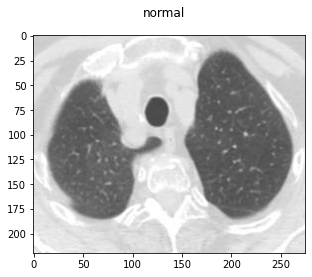

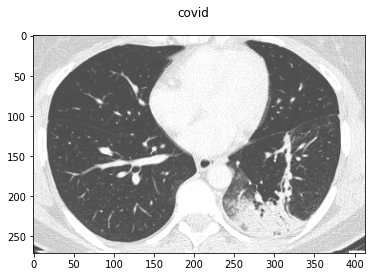

In [18]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

normal_images = []
for img_path in glob.glob(data + '/non-COVID/*'):
    normal_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('normal')
plt.imshow(normal_images[0], cmap='gray') 

covid_images = []
for img_path in glob.glob(data + '/COVID/*'):
    covid_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('covid')
plt.imshow(covid_images[0], cmap='gray') 

In [19]:
print(len(normal_images))
print(len(covid_images))

1229
1252


In [20]:
input_shape = (150, 150, 3)
classes  = 2
epochs = 20
batch_size = 6

In [21]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(Conv2D(250,(3,3)))
model.add(Activation("relu"))
model.add(Dropout(0.2))



  
model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))
model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))
model.add(Dropout(0.2))


model.add(Conv2D(256,(2,2)))
model.add(Activation("relu"))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))

    
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation("sigmoid"))

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



In [23]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)       

In [24]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    data,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    data, 
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary',
    shuffle= False,
    subset='validation')

Found 1986 images belonging to 2 classes.
Found 495 images belonging to 2 classes.


In [25]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("cnn.h5", monitor='accuracy', verbose=1, save_best_only=True)

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=20)

In [26]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = epochs,
 callbacks=[callback,checkpoint]
)

Epoch 1/20
331/331 [==============================] - 26s 77ms/step - loss: 0.7169 - accuracy: 0.4622 - val_loss: 0.6905 - val_accuracy: 0.4919

Epoch 00001: accuracy improved from -inf to 0.46224, saving model to cnn.h5
Epoch 2/20
331/331 [==============================] - 25s 75ms/step - loss: 0.7030 - accuracy: 0.5010 - val_loss: 0.6627 - val_accuracy: 0.4888

Epoch 00002: accuracy improved from 0.46224 to 0.50101, saving model to cnn.h5
Epoch 3/20
331/331 [==============================] - 23s 69ms/step - loss: 0.7003 - accuracy: 0.5065 - val_loss: 0.7455 - val_accuracy: 0.5215

Epoch 00003: accuracy improved from 0.50101 to 0.50655, saving model to cnn.h5
Epoch 4/20
331/331 [==============================] - 23s 68ms/step - loss: 0.6806 - accuracy: 0.5977 - val_loss: 0.5630 - val_accuracy: 0.6687

Epoch 00004: accuracy improved from 0.50655 to 0.59768, saving model to cnn.h5
Epoch 5/20
331/331 [==============================] - 23s 68ms/step - loss: 0.6350 - accuracy: 0.6727 - val

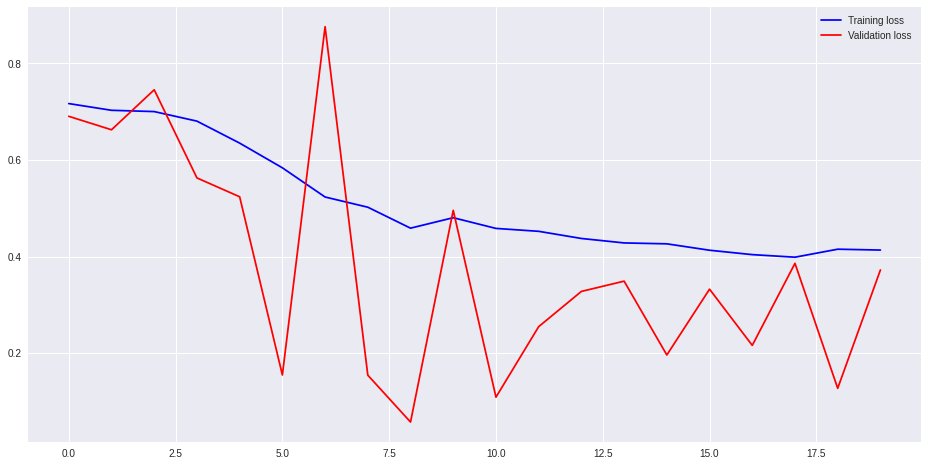

<Figure size 576x396 with 0 Axes>

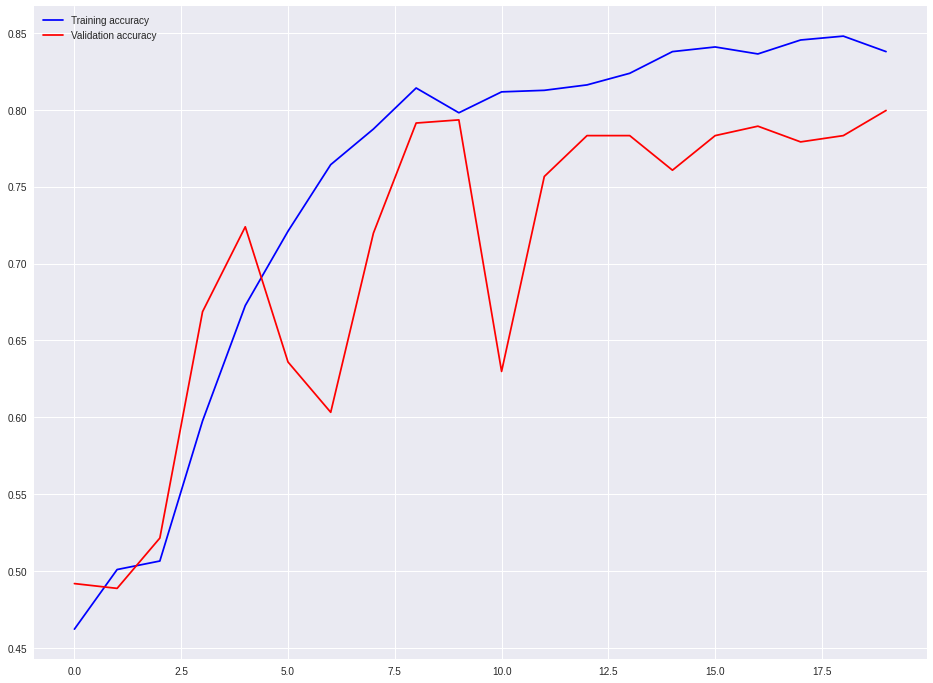

In [27]:
plt.style.use('seaborn')
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(16,12))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.show()

In [28]:
model.evaluate(validation_generator)


83/83 [==============================] - 4s 54ms/step


[0.19631071388721466, 0.7838383913040161]

In [29]:
model.evaluate(train_generator)


331/331 [==============================] - 18s 55ms/step


[0.08775093406438828, 0.8771399855613708]

In [30]:
#define input shape
INPUT_SHAPE = (150,150,3) 

In [31]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input


vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(150,150,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model2 = Sequential()
model2.add(vgg19)
model2.add(Flatten())
model2.add(Dense(1,activation='sigmoid'))
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 8193      
Total params: 20,032,577
Trainable params: 8,193
Non-trainable params: 20,024,384
_________________________________________________________________


In [32]:
model2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [33]:
history_vgg19 = model2.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 5,
 callbacks=[callback,checkpoint]
)

Epoch 1/5
331/331 [==============================] - 25s 77ms/step - loss: 0.5219 - accuracy: 0.7316 - val_loss: 0.1967 - val_accuracy: 0.7947

Epoch 00001: accuracy did not improve from 0.84794
Epoch 2/5
331/331 [==============================] - 24s 74ms/step - loss: 0.3904 - accuracy: 0.8187 - val_loss: 0.3752 - val_accuracy: 0.7996

Epoch 00002: accuracy did not improve from 0.84794
Epoch 3/5
331/331 [==============================] - 27s 81ms/step - loss: 0.3308 - accuracy: 0.8651 - val_loss: 0.1084 - val_accuracy: 0.8119

Epoch 00003: accuracy improved from 0.84794 to 0.86506, saving model to cnn.h5
Epoch 4/5
331/331 [==============================] - 25s 74ms/step - loss: 0.3050 - accuracy: 0.8706 - val_loss: 0.1873 - val_accuracy: 0.8016

Epoch 00004: accuracy improved from 0.86506 to 0.87059, saving model to cnn.h5
Epoch 5/5
331/331 [==============================] - 25s 74ms/step - loss: 0.2793 - accuracy: 0.8907 - val_loss: 0.0631 - val_accuracy: 0.7975

Epoch 00005: accurac

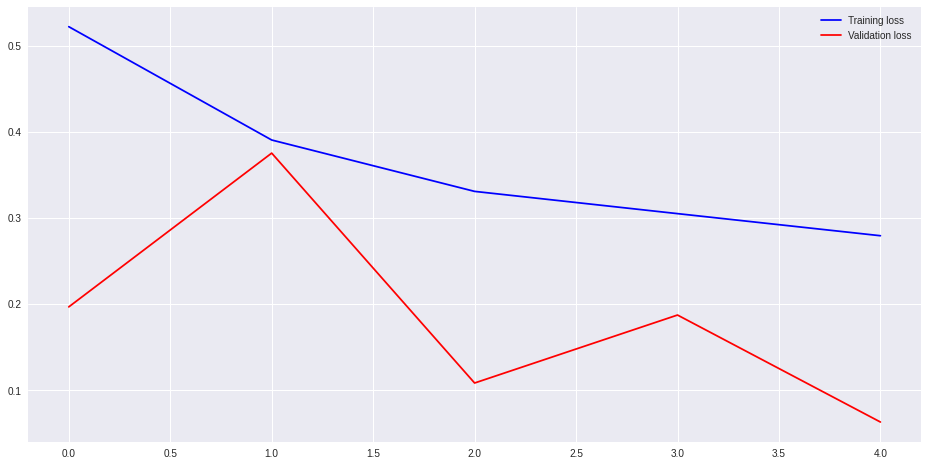

<Figure size 576x396 with 0 Axes>

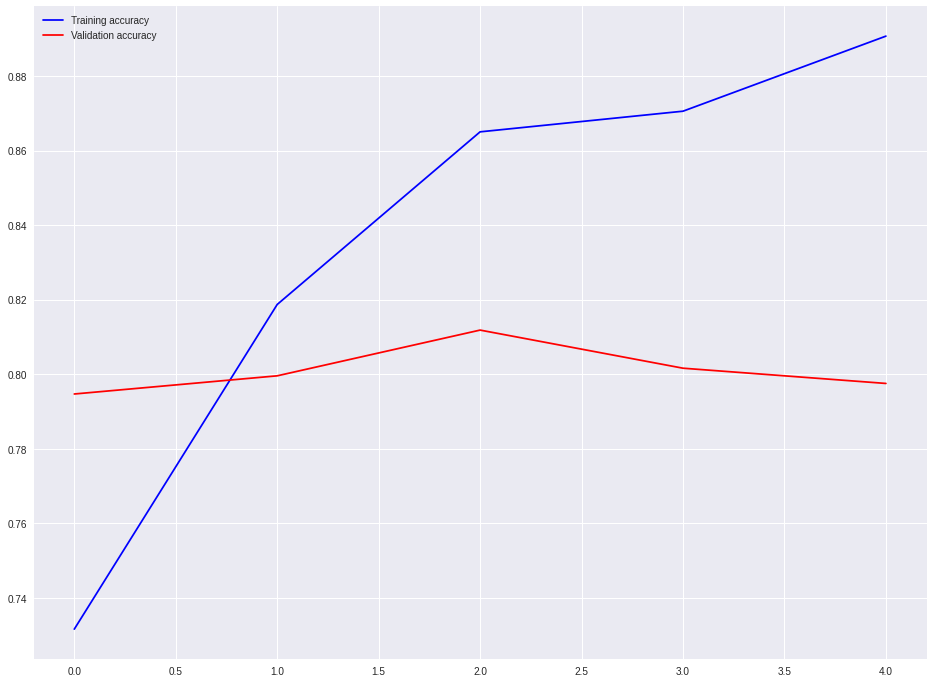

In [34]:
plt.style.use('seaborn')
plt.figure(figsize=(16,8))
plt.plot(history_vgg19.history['loss'], color='b', label="Training loss")
plt.plot(history_vgg19.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(16,12))
plt.plot(history_vgg19.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history_vgg19.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.show()

In [35]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input


vgg16 = VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))

for layer in vgg16.layers:
    layer.trainable = False
    
model3 = Sequential()
model3.add(vgg16)
model3.add(Flatten())
model3.add(Dense(1,activation='sigmoid'))
model3.summary()

58892288/58889256 [==============================] - 6s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 8193      
Total params: 14,722,881
Trainable params: 8,193
Non-trainable params: 14,714,688
_________________________________________________________________


In [36]:
model3.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [37]:
history_vgg16 = model3.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 10,
 callbacks=[callback,checkpoint]
)

Epoch 1/10
331/331 [==============================] - 25s 74ms/step - loss: 0.4696 - accuracy: 0.7714 - val_loss: 0.3004 - val_accuracy: 0.7927

Epoch 00001: accuracy did not improve from 0.89074
Epoch 2/10
331/331 [==============================] - 24s 71ms/step - loss: 0.3166 - accuracy: 0.8661 - val_loss: 0.0701 - val_accuracy: 0.7444

Epoch 00002: accuracy did not improve from 0.89074
Epoch 3/10
331/331 [==============================] - 24s 72ms/step - loss: 0.2821 - accuracy: 0.8812 - val_loss: 0.1398 - val_accuracy: 0.7648

Epoch 00003: accuracy did not improve from 0.89074
Epoch 4/10
331/331 [==============================] - 24s 71ms/step - loss: 0.2673 - accuracy: 0.8852 - val_loss: 0.0696 - val_accuracy: 0.7076

Epoch 00004: accuracy did not improve from 0.89074
Epoch 5/10
331/331 [==============================] - 24s 72ms/step - loss: 0.2466 - accuracy: 0.9033 - val_loss: 0.0169 - val_accuracy: 0.7485

Epoch 00005: accuracy improved from 0.89074 to 0.90332, saving model to

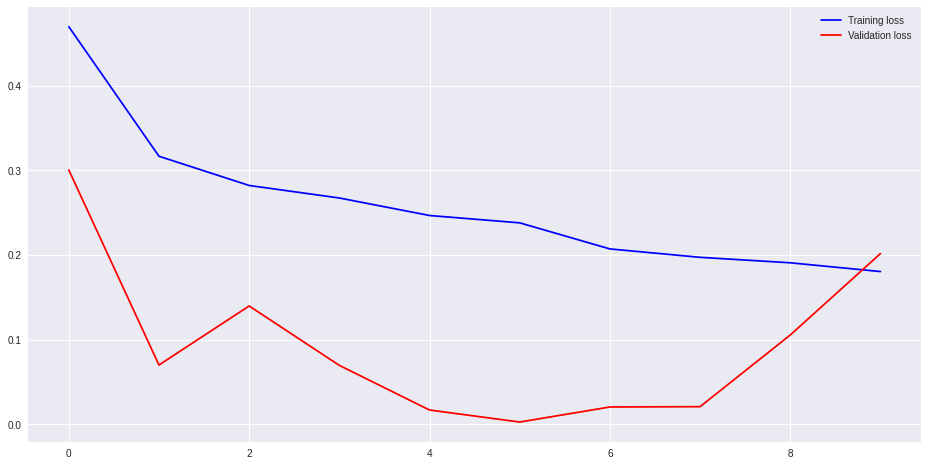

<Figure size 576x396 with 0 Axes>

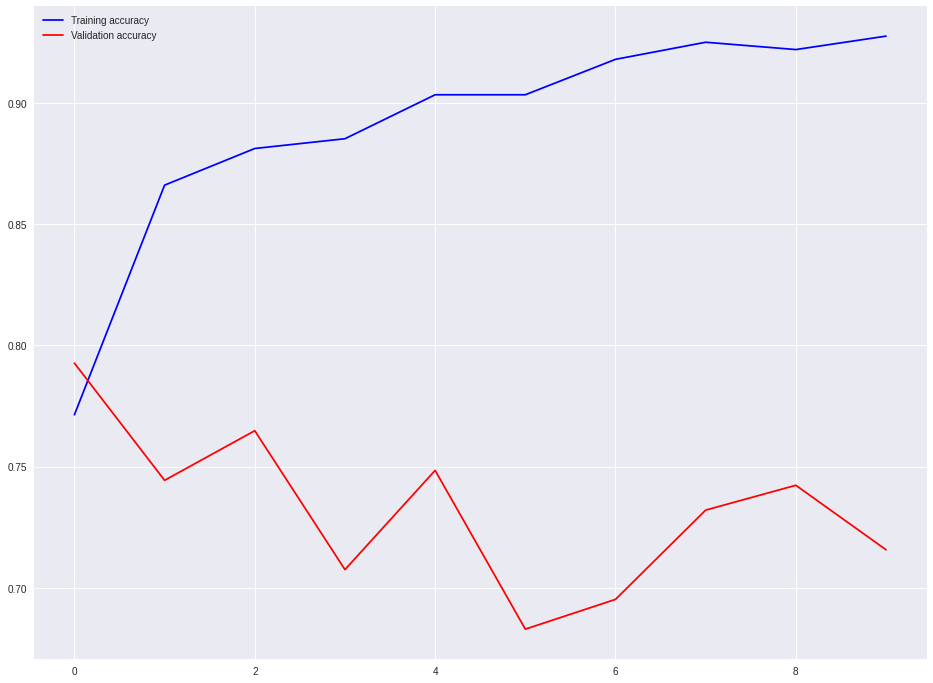

In [38]:
plt.style.use('seaborn')
plt.figure(figsize=(16,8))
plt.plot(history_vgg16.history['loss'], color='b', label="Training loss")
plt.plot(history_vgg16.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(16,12))
plt.plot(history_vgg16.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history_vgg16.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.show()